In [3]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as la

from matplotlib import pyplot as plt
#%matplotlib notebook
%matplotlib inline

Crv.shape =  (6, 1250)


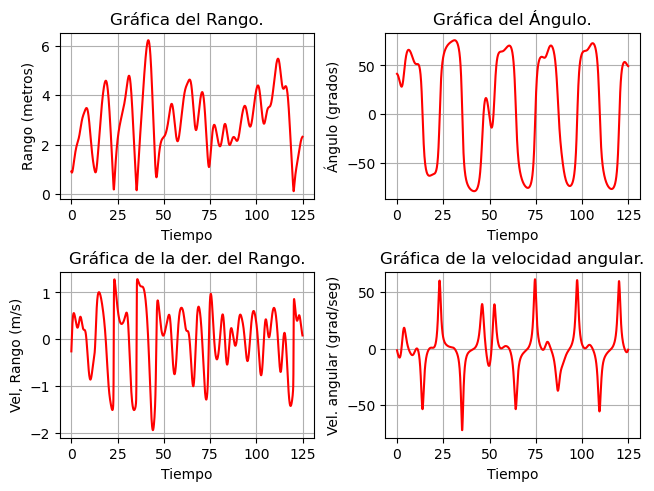

In [4]:
# Cargamos un archivo que contiene un trayectoria.
datTray = np.load("curveMG2.npz")

# Extraemos la información importante.
Crv = datTray['Crv']  # Curva y sys derivadas en coordenadas espaciales.
iCrv = datTray['iCrv']  # Curva proyectada y sus coordenadas espaciales en la imagen.
Z = datTray['Z']  # Distancia entre la cámara y la superficie donde se mueve el obj.

_, N = Crv.shape  #Obtenemos el número de muestras con el que contamos.

# El intervalo de tiempo entre muestras.
dt = 0.1

#Le añadimos ruido a las mediciones de la trayectoria y generamos los datos de medición.
#definimos en ruido de medicion.
varRnge = 02.5
varTheta = 0.0025
varVelRnge = 1.5 * 10e-4
varVelTheta = 1.5 * 10e-5

N -= 1

t = np.linspace(0, dt * N, N)

factNR = 1.

# Definimos el ruido de medición que vamos a añadir a los datos.
noiseRnge = rnd.normal(0, np.sqrt(varRnge), (1, N))
noiseTheta = rnd.normal(0, np.sqrt(varTheta), (1, N))
noiseVRnge = rnd.normal(0, np.sqrt(varVelRnge), (1, N))
noiseVTheta = rnd.normal(0, np.sqrt(varVelTheta), (1, N))

print("Crv.shape = ", Crv.shape)

Crv[0, :] *= 10
Crv[1, :] *= 10

Crv[0, :] -= np.mean(Crv[0, :])
Crv[1, :] -= np.mean(Crv[1, :])

# Definimos el valor real de la trayectora del objeto, y su derivada.
rnge = np.sqrt(Crv[0, :] ** 2 + Crv[1, :] ** 2)
theta = np.arctan(Crv[1, :], Crv[0, :])
z = np.vstack([rnge[:N], theta[:N], np.diff(rnge) / dt, np.diff(theta) / dt])

# Definimos la señal con la que vamos a trabajar: redondeando z y añadiendole error.
zn = np.round(np.round(z) + factNR * np.vstack([noiseRnge, noiseTheta, noiseVRnge, noiseVTheta]), 1)
z.shape

figA, (axA0, axA1) = plt.subplots(2, 2, layout='constrained')
axA0[0].plot(t, z[0, :], 'r')
axA0[0].set(xlabel='Tiempo', ylabel='Rango (metros)',
            title='Gráfica del Rango.')
axA0[0].grid()

axA0[1].plot(t, z[1, :] * 180 / np.pi, 'r')
axA0[1].set(xlabel='Tiempo', ylabel='Ángulo (grados)',
            title='Gráfica del Ángulo.')
axA0[1].grid()

axA1[0].plot(t, z[2, :], 'r')
axA1[0].set(xlabel='Tiempo', ylabel='Vel, Rango (m/s)',
            title='Gráfica de la der. del Rango.')
axA1[0].grid()

axA1[1].plot(t, z[3, :] * 180 / np.pi, 'r')
axA1[1].set(xlabel='Tiempo', ylabel='Vel. angular (grad/seg)',
            title='Gráfica de la velocidad angular.')
axA1[1].grid()

# "Matriz" de transicion de estado.

$$\begin{aligned}
\mathbf{x_k} & =  x_{k-1} + \dot{x}_{k-1} \Delta t^2 + \frac{1}{2}\ddot{x}{\Delta t}^2 
\end{aligned}$$
$$\begin{aligned}
\mathbf{y_k} & =  y_{k-1} + \dot{y}_{k-1} \Delta t^2 + \frac{1}{2}\ddot{y}{\Delta t}^2 
\end{aligned}$$

$$
\begin{aligned}
\mathbf{A} & =  \left[\begin{array}{cccccc}
1 &\Delta t & 0.5\Delta t^2 & 0  & 0 & 0\\
0 & 1 & \Delta t & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & \Delta t & 0.5\Delta t^2\\
0 & 0 & 0 & 0 & 1 &\Delta t\\
0 & 0 & 0 & 0 & 0 & 1\\
\end{array}\right]
\end{aligned}
$$

In [5]:
_A = np.eye(6)  # "Matriz" de transicion de estado.
_A[0, 1] = dt
_A[1, 2] = dt
_A[3, 4] = dt
_A[4, 5] = dt

_A[0, 2] = 0.5 * dt ** 2
_A[3, 5] = 0.5 * dt ** 2

print("_A = \n", _A)

_A = 
 [[1.    0.1   0.005 0.    0.    0.   ]
 [0.    1.    0.1   0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.1   0.005]
 [0.    0.    0.    0.    1.    0.1  ]
 [0.    0.    0.    0.    0.    1.   ]]


# "Matriz" de incertidumbre del estado.

In [6]:
# px,   pxx',   px'x,   0,     0,       0
# px'x, px',    px'x'', 0,     0,       0
# px''x,px''x', px'',   0,     0,       0
# 0,    0,      0,      py,    pyy',   pyy''
# 0,    0,      0,      py'y,  py',    py'y''
# 0,    0       0,      py''y, py''y', py''

# px    is the variance of the X coordinate position estimation
px = 1.0
# px'   is the variance of the X coordinate velocity estimation
px_dot = 0.1
# px''  is the variance of the X coordinate acceleration estimation
px_ddot = 0.01
# py    is the variance of the Y coordinate position estimation
py = 1.0
# py'   is the variance of the Y coordinate velocity estimation
py_dot = 0.1
# py''  is the variance of the Y coordinate acceleration estimation
py_ddot = 0.01

# Pxx'  is the multiplication of the standard deviations of Px and Px', that is sqrt(Px)*sqrt(Px')
# Px'x  is the multiplication of the standard deviations of Px' and Px, that is sqrt(Px')*sqrt(Px)
# Px'x'' is the multiplication of the standard deviations of Px' and Px'', that is sqrt(Px')*sqrt(Px'')
# and so on.

# desviaciones estándar
std_px = np.sqrt(px)
std_px_dot = np.sqrt(px_dot)
std_px_ddot = np.sqrt(px_ddot)
std_py = np.sqrt(py)
std_py_dot = np.sqrt(py_dot)
std_py_ddot = np.sqrt(py_ddot)

_P = np.zeros((6, 6))
_P[0, 0] = px
_P[1, 1] = px_dot
_P[2, 2] = px_ddot
_P[3, 3] = py
_P[4, 4] = py_dot
_P[5, 5] = py_ddot

_P[0, 1] = _P[1, 0] = std_px * std_px_dot  # Pxx'
_P[1, 0] = _P[0, 1]  # Px'x
_P[1, 2] = _P[2, 1] = std_px_dot * std_px_ddot  # Px'x''
_P[2, 1] = _P[1, 2]  # Px''x'
_P[0, 2] = _P[2, 0] = 0  # Px, Px''
_P[3, 4] = _P[4, 3] = std_py * std_py_dot  # Py, Py'
_P[4, 3] = _P[3, 4]  # Py'x
_P[4, 5] = _P[5, 4] = std_py_dot * std_py_ddot  # Py', Py''
_P[5, 4] = _P[4, 5]

print("_P = \n", _P)

_P = 
 [[1.         0.31622777 0.         0.         0.         0.        ]
 [0.31622777 0.1        0.03162278 0.         0.         0.        ]
 [0.         0.03162278 0.01       0.         0.         0.        ]
 [0.         0.         0.         1.         0.31622777 0.        ]
 [0.         0.         0.         0.31622777 0.1        0.03162278]
 [0.         0.         0.         0.         0.03162278 0.01      ]]


 # "Matriz" de incertidumbre de la predicción.

In [7]:
# σ²x      σ²xx'     σ²xx''    0         0         0
# σ²x'x    σ²x'      σ²x'x''   0         0         0
# σ²x''x   σ²x''x'   σ²x''     0         0         0
# 0        0         0         σ²y       σ²yy'     σ²yy''
# 0        0         0         σ²y'y     σ²y'      σ²y'y''
# 0        0         0         σ²y''y    σ²y''y'   σ²y''
_Q = np.zeros((6, 6))
_Q[0, 0] = _Q[3, 3] = (dt ** 4) / 4
_Q[0, 1] = _Q[1, 0] = (dt ** 3) / 2
_Q[3, 4] = _Q[4, 3] = (dt ** 3) / 2
_Q[0, 2] = _Q[2, 0] = (dt ** 2) / 2
_Q[3, 5] = _Q[3, 3] = (dt ** 2) / 2
_Q[1, 1] = _Q[4, 4] = (dt ** 2)
_Q[1, 2] = _Q[2, 1] = dt
_Q[4, 5] = _Q[5, 4] = dt
_Q[2, 2] = _Q[5, 5] = 1

# _Q = _Q * σ2(random variance in acceleration)
_Q = _Q * 1e-9

print("_Q = \n", _Q)

_Q = 
 [[2.5e-14 5.0e-13 5.0e-12 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-13 1.0e-11 1.0e-10 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-12 1.0e-10 1.0e-09 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-12 5.0e-13 5.0e-12]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-13 1.0e-11 1.0e-10]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e-10 1.0e-09]]


## Matriz Jacobiana


 \begin{bmatrix}
\frac{x}{\sqrt{x^2 + y^2}} & 0 & 0 & \frac{y}{\sqrt{x^2 + y^2}} & 0 & 0 \\
-\frac{y}{x^2 + y^2} & 0 & 0 & \frac{x}{x^2 + y^2} & 0 & 0
\end{bmatrix}


In [8]:
def jacobian_h(x, y):
    r = np.sqrt(x ** 2 + y ** 2)
    H = np.array([
        [x / r, 0, 0, y / r, 0, 0],
        [-y / (x ** 2 + y ** 2), 0, 0, x / (x ** 2 + y ** 2), 0, 0]
    ])
    return H


print(jacobian_h(1, 1))

[[ 0.70710678  0.          0.          0.70710678  0.          0.        ]
 [-0.5         0.          0.          0.5         0.          0.        ]]


## Matriz de Covarianza de la Medición 

\begin{bmatrix}
\sigma^2_{r,m} & 0 \\
0 & \sigma^2_{\phi,m}
\end{bmatrix}


In [9]:
def measurement_covariance(sigma_r, sigma_phi):
    R = np.array([
        [sigma_r ** 2, 0],
        [0, sigma_phi ** 2]
    ])
    return R


print(measurement_covariance(1, 1))

[[1 0]
 [0 1]]


## Matriz de Control \( B \)

considerando que el control se basa en la aceleración Uk=[ax,ay]T, entonces

\[
B = \begin{bmatrix} 
\frac{\Delta t^2}{2} & 0 \\ 
\Delta t & 0 \\ 
1 & 0 \\ 
0 & \frac{\Delta t^2}{2} \\ 
0 & \Delta t \\ 
0 & 1 
\end{bmatrix}
\]

In [10]:
delta_t = 1.0  # Intervalo de tiempo en segundos

# Matriz de control B
_B = np.array([[0.5 * dt ** 2, 0, 0],
               [dt, 0, 0],
               [1, 0, 0],
               [0, 0.5 * dt ** 2, 0],
               [0, dt, 0],
               [0, 0, 1]])
# Matriz de medición H
_H = np.array([
    [1, 0, 0, 0, 0, 0],  # Medición de posición x
    [0, 1, 0, 0, 0, 0],  # Medición de posición y
    [0, 0, 1, 0, 0, 0],  # Medición de velocidad en x
    [0, 0, 0, 1, 0, 0]   # Medición de velocidad en y
])
H = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0]]) 


In [11]:
sigma_Rnge = varRnge  # desviación estándar en la medición de rango
sigma_Theta_m = varTheta  # desviación estándar en la medición de ángulo
# Matriz de incertidumbre de medición R
_R = np.array([
    [sigma_Rnge ** 2, 0],
    [0, sigma_Theta_m ** 2]
])
_R = np.diag([sigma_Rnge**2, sigma_Theta_m**2, varVelRnge**2, varVelTheta**2])
print("R = \n", _R)
# _R = np.eye(2) * 0.1

R = 
 [[6.25e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 6.25e-06 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 2.25e-06 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 2.25e-08]]


In [12]:
# Definir nuestro sistema.

A = _A  #"Matriz" de transicion de estado.
B = _B  #"Matriz" de control.
H = _H  #"Matriz" de medición.
P = _P  #"Matriz" de incertidumbre del estado.
Q = _Q  #"Matriz" de incertidumbre de la predicción.
R = _R  #Matriz de incertidumbre de medición.


In [13]:
# $\hat{x}_{k-1}$ => xhat_k0
# $\hat{x}_{k}$ => xhat_k1
# $\bar{x}_{k}$ => xbar_k1

def KalmanFilter(Xhat_k0, Phat_k0, U_k1, Z_k, A, B, H, Q, R):
    #Predicción
    Xbar_k1 = np.dot(A, Xhat_k0) + np.dot(B, U_k1)
    Pbar_k1 = np.dot(A, np.dot(Phat_k0, A.transpose())) + Q

    #Actualización

    #Calculamos la ganancia.
    denom = np.dot(np.dot(H, Pbar_k1), H.transpose()) + R
    if len(denom) > 1:
        denom = la.inv(denom)
    else:
        denom = 1. / denom
    Kgain = np.dot(np.dot(Pbar_k1, H.transpose()), denom)
    
    # Actualizamos el Estado y su incertidumbre.
    Xhat_k1 = Xbar_k1 + np.dot(Kgain, (Z_k - np.dot(H, Xbar_k1)))
    Phat_k1 = np.dot(np.eye(len(Xhat_k0)) - np.dot(Kgain, H), Pbar_k1)

    return Xhat_k1, Phat_k1, Xbar_k1


In [14]:
# 1. Inicializar el estado y la matriz de incertidumbre
x = np.zeros((6, N))  # Estado: [x, vx, ax, y, vy, ay]
x[:, 0] = np.array([0, 0, 0, 0, 0, 0])  # Inicializar en el origen

# Inicializar las listas para almacenar las estimaciones
Xhat = np.zeros((6, N))  # Estimaciones del estado
# x_hat[:, 0] = x[:, 0]
Xbar=np.zeros((6, N))
Phat=np.zeros((6,6,N))
trP=np.zeros(N)

# x_hat[:,0], Phat[:,:,0] = x[:, 0], P0

# 2. Ejecutar el filtro de Kalman usando la función definida
for idx in range(1, N):
    # Obtener la medición
    z_k = zn[:, idx]
    
    U_k1 = np.array([0, 0, 0])  

    Xhat[:, idx], Phat[:,:,idx], Xbar[:, idx]  = KalmanFilter(
        Xhat[:,idx-1],  # Estado anterior
        Phat[:,:,idx-1],  # Matriz de incertidumbre anterior
        U_k1,  # Vector de control
        z_k,  # Medición
        A,  # Matriz de transición de estado
        B,  # Matriz de control
        H,  # Matriz de medición
        Q,  # Matriz de incertidumbre de la predicción
        R  # Matriz de incertidumbre de medición
    )
    trP[idx-1]= np.sum(np.sqrt(np.diag(Phat[:4,:4,idx])))


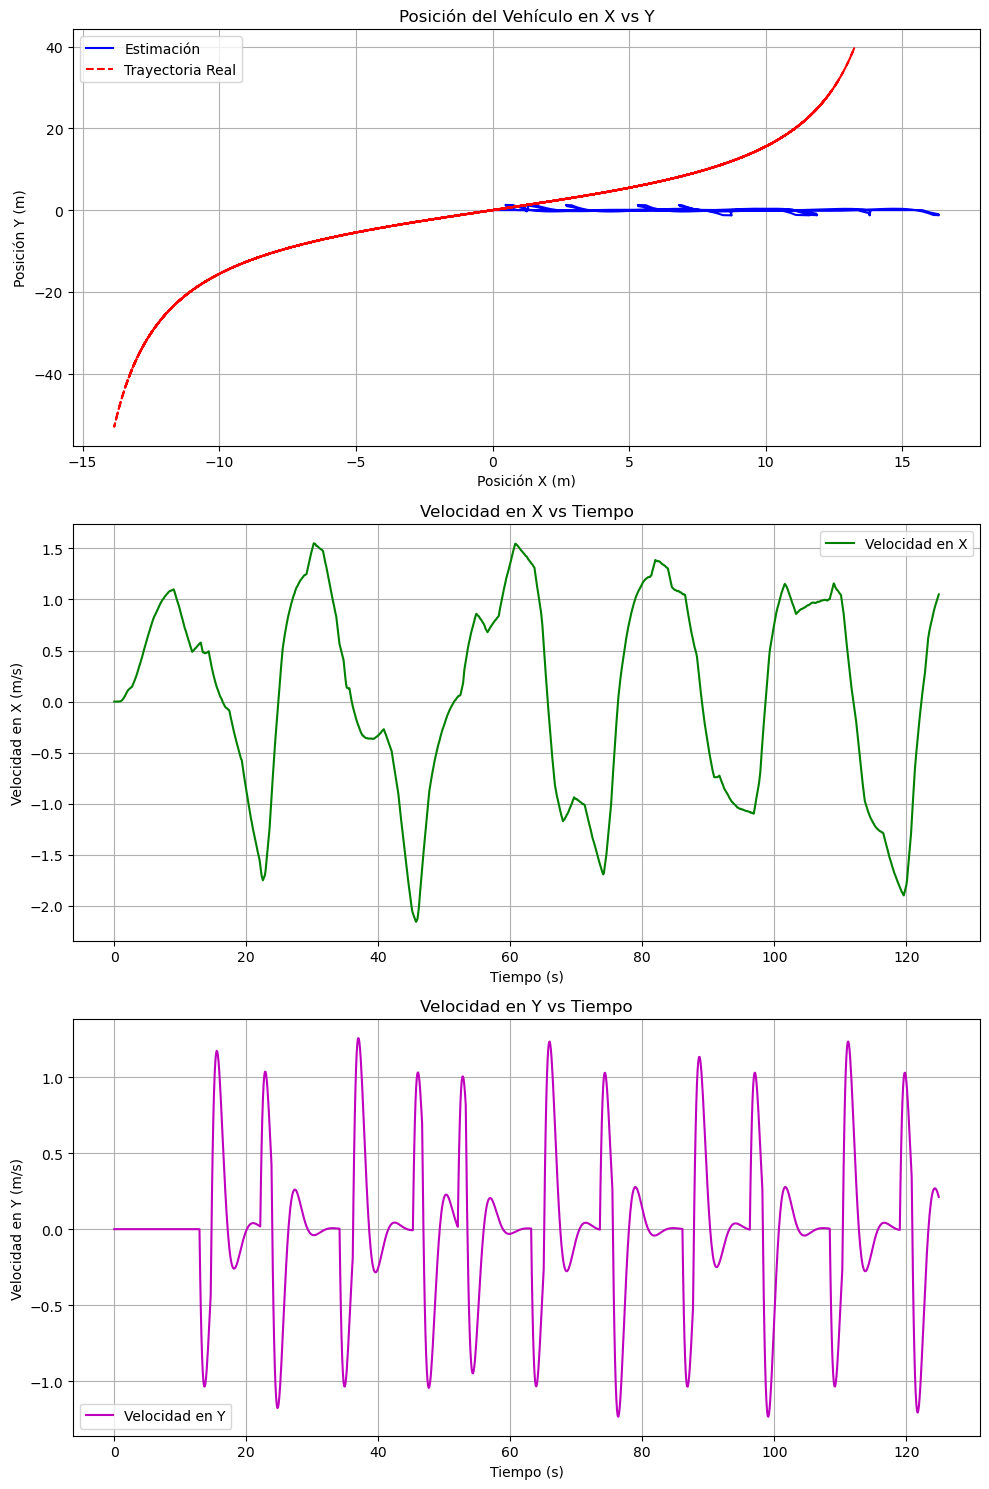

In [15]:
# 3. Visualizar los resultados
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Posición del vehículo en X vs Y
ax1.plot(Xhat[0, :], Xhat[3, :], label='Estimación', color='b')
ax1.plot(Crv[0, :] * 10, Crv[1, :] * 10, label='Trayectoria Real', color='r', linestyle='--')
ax1.set_title('Posición del Vehículo en X vs Y')
ax1.set_xlabel('Posición X (m)')
ax1.set_ylabel('Posición Y (m)')
ax1.legend()
ax1.grid()

# Velocidad en X vs tiempo
ax2.plot(t, Xhat[1, :], label='Velocidad en X', color='g')
ax2.set_title('Velocidad en X vs Tiempo')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Velocidad en X (m/s)')
ax2.legend()
ax2.grid()

# Velocidad en Y vs tiempo
ax3.plot(t, Xhat[4, :], label='Velocidad en Y', color='m')
ax3.set_title('Velocidad en Y vs Tiempo')
ax3.set_xlabel('Tiempo (s)')
ax3.set_ylabel('Velocidad en Y (m/s)')
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()